In [112]:
#install Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from fuzzywuzzy import process
from folium.plugins import FastMarkerCluster
from folium.plugins import HeatMap
from folium.plugins import MarkerCluster

In [ ]:
#Define Functions
def map_phase(code):
    """Maps a given phase code of flight to a more broad phase.
    Use this for Pre-2008 data with numeric phase codes."""
    try:
        code = int(code)
    except:
        return 'Unknown'
    if 130 <= code <= 139:
        return 'Mechanical'
    elif 190 <= code <= 196:
        return 'Landing'
    elif code == 197:
        return 'Takeoff'
    elif code == 198:
        return 'Taxi'
    elif code == 200 or code == 231 or code == 232:
        return 'Landing'
    elif 310 <= code <= 330:
        return 'Taxi'
    elif 500 <= code <= 514:
        return 'Taxi'
    elif 520 <= code <= 523:
        return 'Takeoff'
    elif 530 <= code <= 539:
        return 'Climb'
    elif 540 <= code <= 549:
        return 'Cruise'
    elif 550 <= code <= 559:
        return 'Descent'
    elif 560 <= code <= 569:
        return 'Approach'
    elif 570 <= code <= 579:
        return 'Landing'
    # elif 580 <= code <= 589:
    #     return 'Cruise'
    else:
        return 'Other/Unknown'



def match_phase(desc):
    """Uses Fuzzy Matching to match a given description to a phase of flight.
    Use this for Post-2008 data with text descriptions."""
    match = process.extractOne(desc, phases, score_cutoff=50) 
    return match[0] if match else 'Other/Unknown'

In [ ]:
##Read in Appropriate CSVs starting with Pre-2008 Data

# Load Pre-2008
pre_events = pd.read_csv("pre2008events.csv")[['ev_id','ev_date','mid_air','dec_latitude','dec_longitude','ev_country']]
pre_aircraft = pd.read_csv("pre2008aircraft.csv")[['ev_id','far_part']]
pre_aircraft['far_part'] = pre_aircraft['far_part'].str.lstrip('0') #remove leading zeros

# Clean dates
pre_events['ev_date'] = pd.to_datetime(pre_events['ev_date'], errors='coerce')
pre_events = pre_events.dropna(subset=['ev_date'])



# Deduplicate aircraft (take first FAR part per event)
pre_aircraft_unique = pre_aircraft.groupby('ev_id', as_index=False).first()

# Merge datasets 
df_pre = pd.merge(pre_events, pre_aircraft_unique, on='ev_id', how='inner')



/var/folders/w6/dztl65ts6kb1321x9p86ck180000gn/T/ipykernel_83111/4248701904.py:5: DtypeWarning: Columns (32,53,59) have mixed types. Specify dtype option on import or set low_memory=False.
  pre_aircraft = pd.read_csv("pre2008aircraft.csv")[['ev_id','far_part']]
/var/folders/w6/dztl65ts6kb1321x9p86ck180000gn/T/ipykernel_83111/4248701904.py:9: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  pre_events['ev_date'] = pd.to_datetime(pre_events['ev_date'], errors='coerce')


In [115]:
#Load Post-2008 Data

post_events = pd.read_csv("events.csv")[['ev_id','ev_date','mid_air','dec_latitude','dec_longitude','ev_country']]
post_aircraft = pd.read_csv("aircraft.csv")[['ev_id','far_part']]
post_aircraft['far_part'] = post_aircraft['far_part'].str.lstrip('0') #remove leading zeros

# Clean dates
post_events['ev_date'] = pd.to_datetime(post_events['ev_date'], errors='coerce')
post_events = post_events.dropna(subset=['ev_date'])

post_aircraft_unique = post_aircraft.groupby('ev_id', as_index=False).first()

# Merge
df_post = pd.merge(post_events, post_aircraft_unique, on='ev_id', how='inner')

/var/folders/w6/dztl65ts6kb1321x9p86ck180000gn/T/ipykernel_83111/3626596044.py:3: DtypeWarning: Columns (0,10,31,51) have mixed types. Specify dtype option on import or set low_memory=False.
  post_events = pd.read_csv("events.csv")[['ev_id','ev_date','mid_air','dec_latitude','dec_longitude','ev_country']]
/var/folders/w6/dztl65ts6kb1321x9p86ck180000gn/T/ipykernel_83111/3626596044.py:4: DtypeWarning: Columns (0,59) have mixed types. Specify dtype option on import or set low_memory=False.
  post_aircraft = pd.read_csv("aircraft.csv")[['ev_id','far_part']]
/var/folders/w6/dztl65ts6kb1321x9p86ck180000gn/T/ipykernel_83111/3626596044.py:8: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  post_events['ev_date'] = pd.to_datetime(post_events['ev_date'], errors='coerce')


In [ ]:

# Combine Pre + Post
df_all = pd.concat([df_pre, df_post], ignore_index=True)
dates_after1986 = '1986-01-01'
today = pd.Timestamp.today().normalize()

# Filter for dates after 1986 and up to today, and only USA
df_all = df_all[pd.to_datetime(df_all['ev_date']) <= today]
df_all = df_all[pd.to_datetime(df_all['ev_date']) >= dates_after1986]
df_all = df_all[df_all['ev_country'] == 'USA']

# Clean up the mid_air column
df_all['mid_air'] = df_all['mid_air'].replace({'Y': 'Yes', 'N': 'No', np.nan: 'No'})


# Convert to period month for grouping
df_all['year_month'] = df_all['ev_date'].dt.to_period('M')

grouped = (
    df_all.groupby(['year_month', 'far_part'])
    .size()
    .reset_index(name='count')
)

pivoted = grouped.pivot(
    index='year_month', columns='far_part', values='count'
).fillna(0)

pivoted.index = pivoted.index.to_timestamp()
desired_parts = ['91','121','135']   # adjust as needed
available_parts = [p for p in desired_parts if p in pivoted.columns]

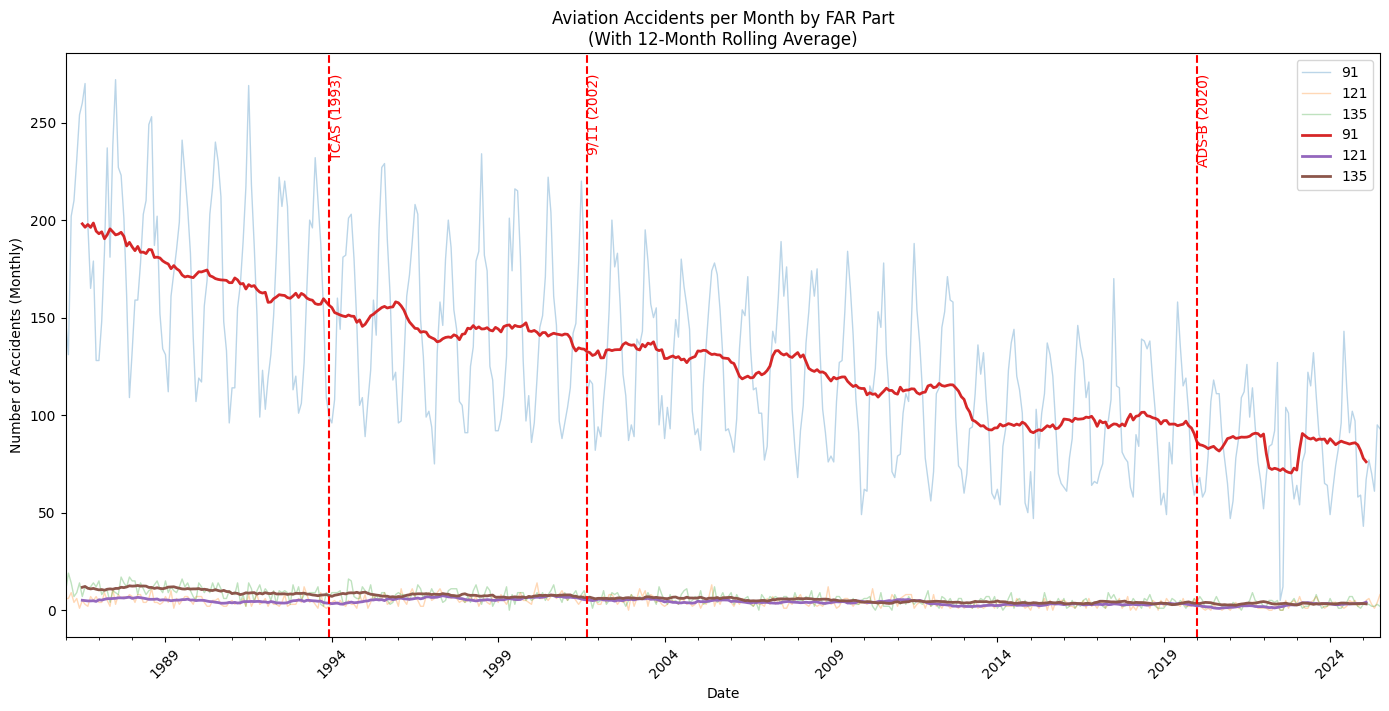

In [ ]:
# Plot a rolling average of accidents over time for selected FAR parts

rolling = pivoted[available_parts].rolling(window=12, center=True).mean()

# Plot original + rolling
rolling_ax = pivoted[available_parts].plot(figsize=(14,7), alpha=0.3, linewidth=1)
rolling.plot(ax=rolling_ax, linewidth=2)
plt.title("Aviation Accidents per Month by FAR Part\n(With 12-Month Rolling Average)")
plt.xlabel("Date")
plt.ylabel("Number of Accidents (Monthly)")
plt.legend(title="FAR Part")
plt.tight_layout()
plt.xticks(rotation=45)
rolling_ax.axvline(pd.Timestamp('2001-09-11'), color='red', linestyle='--') ## 11 September 2001
rolling_ax.axvline(pd.Timestamp('1993-12-31'), color='red', linestyle='--') ## 31 December 1993 TCAS for large aircraft
rolling_ax.axvline(pd.Timestamp('2020-01-01'), color='red', linestyle='--') ## ADS-B mandate for most aircraft


plt.text(pd.Timestamp('2001-09-11'), 275, '9/11 (2002)', color='red', rotation=90, verticalalignment='top')
plt.text(pd.Timestamp('1993-12-31'), 275, 'TCAS (1993)', color='red', rotation=90, verticalalignment='top')
plt.text(pd.Timestamp('2020-01-01'), 275, 'ADS-B (2020)', color='red', rotation=90, verticalalignment='top')
plt.legend()
plt.show()


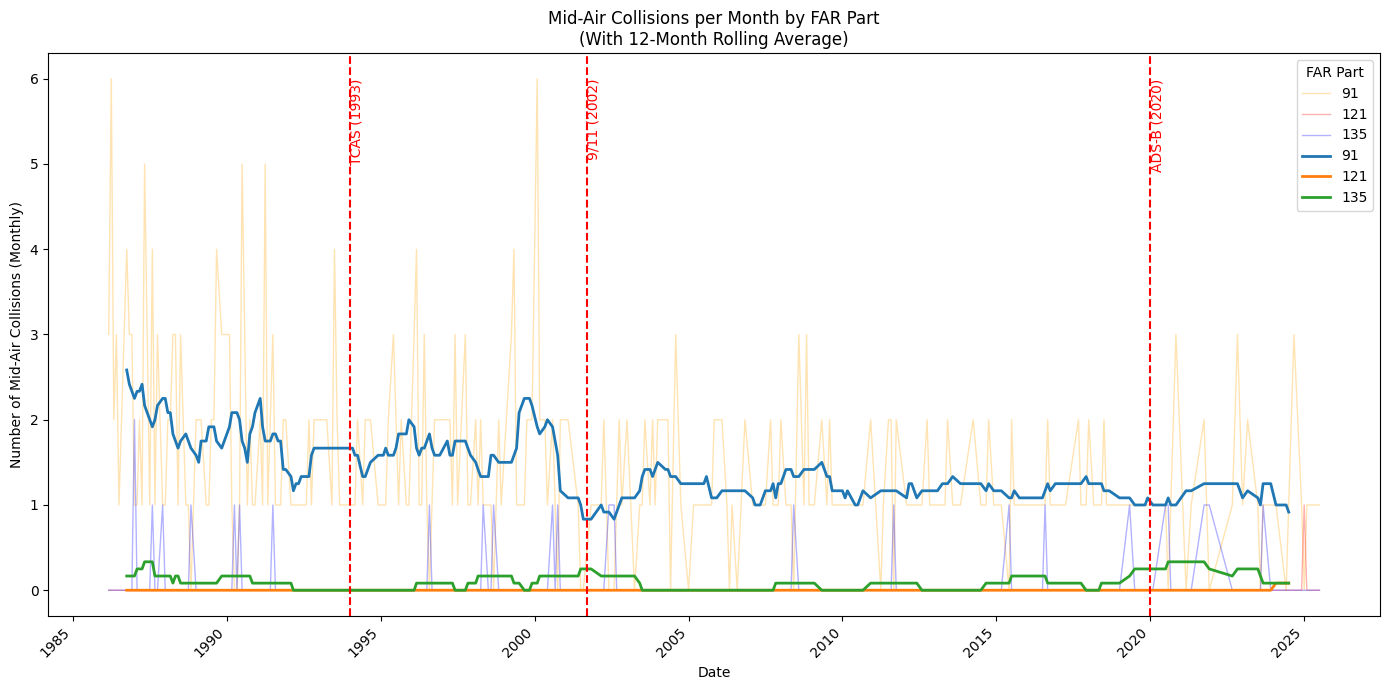

In [ ]:
# Plot number of mid-air collisions per month by available_parts
mid_air_grouped = (
    df_all[df_all['mid_air'] == 'Yes']
    .groupby(['year_month', 'far_part'])
    .size()
    .reset_index(name='count')
)

mid_air_grouped['year_month'] = mid_air_grouped['year_month'].dt.to_timestamp()


mid_air_pivoted = mid_air_grouped.pivot(
    index='year_month', columns='far_part', values='count'
).fillna(0)

mid_air_pivoted = mid_air_pivoted[available_parts]  # Only plot available_parts

mid_air_rolling = mid_air_pivoted.rolling(window=12, center=True).mean()

mid_air_ax = mid_air_pivoted.plot(figsize=(14,7), alpha=0.3, linewidth=1, color=['orange', 'red', 'blue'])
mid_air_rolling.plot(ax=mid_air_ax, linewidth=2)
mid_air_ax.set_title("Mid-Air Collisions per Month by FAR Part\n(With 12-Month Rolling Average)")
mid_air_ax.set_xlabel("Date")
mid_air_ax.set_ylabel("Number of Mid-Air Collisions (Monthly)")
mid_air_ax.legend(title="FAR Part")
mid_air_ax.axvline(pd.Timestamp('2001-09-11'), color='red', linestyle='--', label='9/11 Attacks') ## 11 September 2001
mid_air_ax.axvline(pd.Timestamp('1993-12-31'), color='red', linestyle='--', label='TCAS for Large Aircraft') ## 31 December 1993 TCAS for large aircraft
mid_air_ax.axvline(pd.Timestamp('2020-01-01'), color='red', linestyle='--', label='ADS-B Mandate') ## ADS-B mandate for most aircraft

plt.text(pd.Timestamp('2001-09-11'), 6, '9/11 (2002)', color='red', rotation=90, verticalalignment='top')
plt.text(pd.Timestamp('1993-12-31'), 6, 'TCAS (1993)', color='red', rotation=90, verticalalignment='top')
plt.text(pd.Timestamp('2020-01-01'), 6, 'ADS-B (2020)', color='red', rotation=90, verticalalignment='top')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

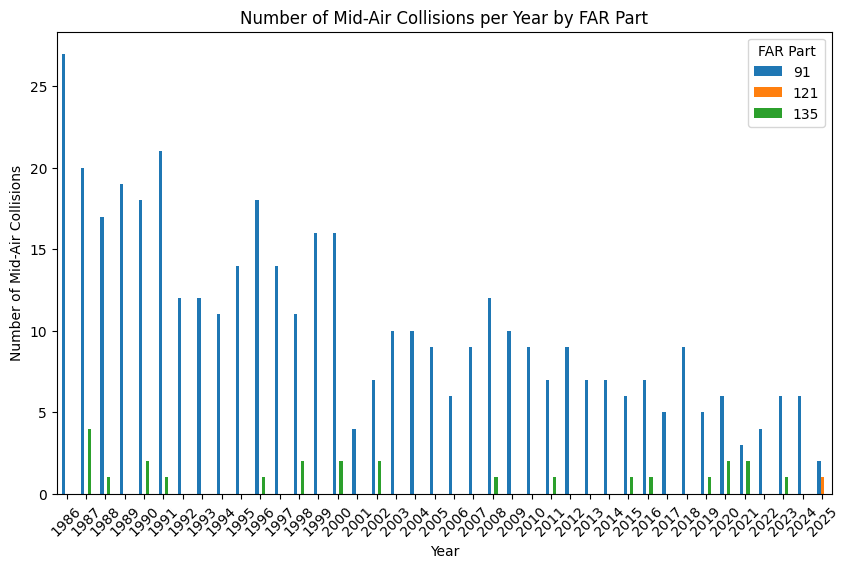

In [119]:
#number of mid-air collisions per year by FAR part 91, 121, 135
mid_air_yearly_far = df_all[df_all['mid_air'] == 'Yes']
mid_air_yearly_far = mid_air_yearly_far.groupby([mid_air_yearly_far['ev_date'].dt.year, 'far_part']).size().unstack(fill_value=0)
mid_air_yearly_far.index.name = 'Year'

# Only plot available_parts columns
mid_air_yearly_far_plot = mid_air_yearly_far[available_parts]

mid_air_yearly_far_plot.plot(kind='bar', stacked=False, figsize=(10,6))


plt.xticks(rotation=45)
plt.title("Number of Mid-Air Collisions per Year by FAR Part")
plt.xlabel("Year")
plt.ylabel("Number of Mid-Air Collisions")
plt.legend(title="FAR Part")
# plt.tight_layout()
plt.show()


In [120]:
##### Record information by each phase of flight for Pre-2008 data
pre2008_phase = pd.read_csv('pre2008Occurrences.csv')
phase_codes = pd.read_csv('ct_seqevt.csv')
pre2008_phase = pre2008_phase[['ev_id','Phase_of_Flight']]


# Merge on Phase_of_Flight from pre2008_phase and code from phase_codes
pre2008_phase = pd.merge(pre2008_phase, phase_codes, left_on='Phase_of_Flight', right_on='code', how='left')
pre2008_phase.groupby('Phase_of_Flight').size().sort_values(ascending=False)
pre2008_phase = pd.merge(pre2008_phase, pre_aircraft, on='ev_id', how='left')
pre2008_phase['far_part'] = pre2008_phase['far_part'].replace('091', '91')

# Apply the mapping
pre2008_phase['Phase_Group'] = pre2008_phase['Phase_of_Flight'].apply(map_phase)

# Group by the bins
phase_summary = pre2008_phase.groupby('Phase_Group').size().sort_values(ascending=False) 

print(phase_summary)


#phase percentages
phase_percentages = (phase_summary / phase_summary.sum()) * 100
print(phase_percentages)

Phase_Group
Landing          52585
Descent          26955
Takeoff          17930
Other/Unknown    13062
Cruise           11972
Approach         11127
Taxi              4374
Climb             2429
dtype: int64
Phase_Group
Landing          37.444636
Descent          19.194070
Takeoff          12.767563
Other/Unknown     9.301166
Cruise            8.525001
Approach          7.923295
Taxi              3.114630
Climb             1.729638
dtype: float64


In [121]:
################### Post 2008 ##########################
post2008_phase = pd.read_csv('Events_Sequence.csv')
post2008_phase = post2008_phase[['ev_id','Occurrence_Description','phase_no']]
post2008_phase = pd.merge(post2008_phase, phase_codes, left_on='phase_no', right_on='code', how='left')
post2008_phase.groupby('phase_no').size().sort_values(ascending=False)
post2008_phase = pd.merge(post2008_phase, post_aircraft, on='ev_id', how='left')


post2008_phase['far_part'] = post2008_phase['far_part'].replace('091', '91')

In [122]:
### Fuzzy Match the Occurrence_Description to known phases for Post 2008
phases = ['Taxi', 'Takeoff', 'Climb', 'Cruise', 'Descent', 'Approach', 'Landing']

post2008_phase['Phase_Group'] = post2008_phase['Occurrence_Description'].apply(match_phase)

In [123]:
post2008_phase['Phase_Group'].value_counts()

Phase_Group
Landing          23271
Other/Unknown     8905
Descent           8761
Takeoff           7313
Approach          5263
Climb             4941
Cruise            3853
Taxi              1432
Name: count, dtype: int64

In [126]:

full_phase_data = pd.concat([pre2008_phase[['ev_id', 'far_part', 'Phase_Group']], post2008_phase[['ev_id', 'far_part', 'Phase_Group']]], ignore_index=True)

In [127]:
full_phase_data.head()

,ev_id,far_part,Phase_Group
0,20001204X00055,91,Descent
1,20001204X00056,91,Approach
2,20001204X00056,91,Landing
3,20001204X00056,91,Landing
4,20001204X00057,91,Approach


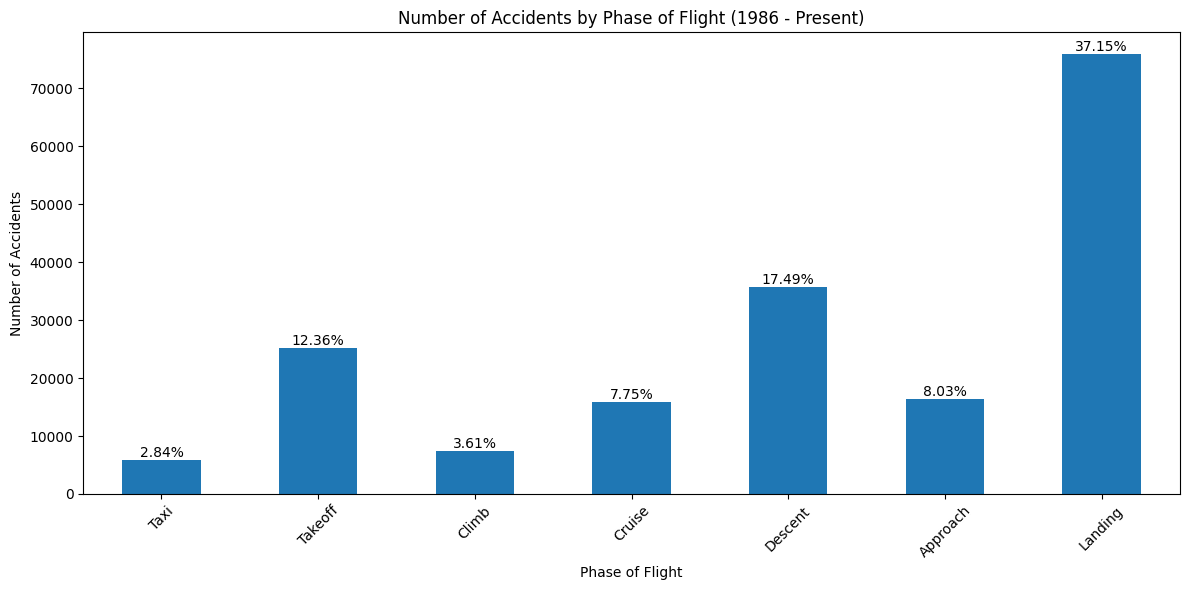

In [ ]:
# phase_order = ['Taxi', 'Takeoff', 'Climb', 'Cruise', 'Descent', 'Approach', 'Landing', 'Mechanical', 'Other/Unknown']
phase_order = ['Taxi', 'Takeoff', 'Climb', 'Cruise', 'Descent', 'Approach', 'Landing']

full_phase_data['Phase_Group'].value_counts().reindex(phase_order).plot(kind='bar', figsize=(12,6))
for i, v in enumerate(full_phase_data['Phase_Group'].value_counts().reindex(phase_order)):
    # plt.text(i, v + 3, str(v), ha='center', va='bottom')

    percentage = (v / full_phase_data['Phase_Group'].count()) * 100
    plt.text(i, v + 3, f'{percentage:.2f}%', ha='center', va='bottom')

plt.title('Number of Accidents by Phase of Flight (1986 - Present)')
plt.xlabel('Phase of Flight')
plt.ylabel('Number of Accidents')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


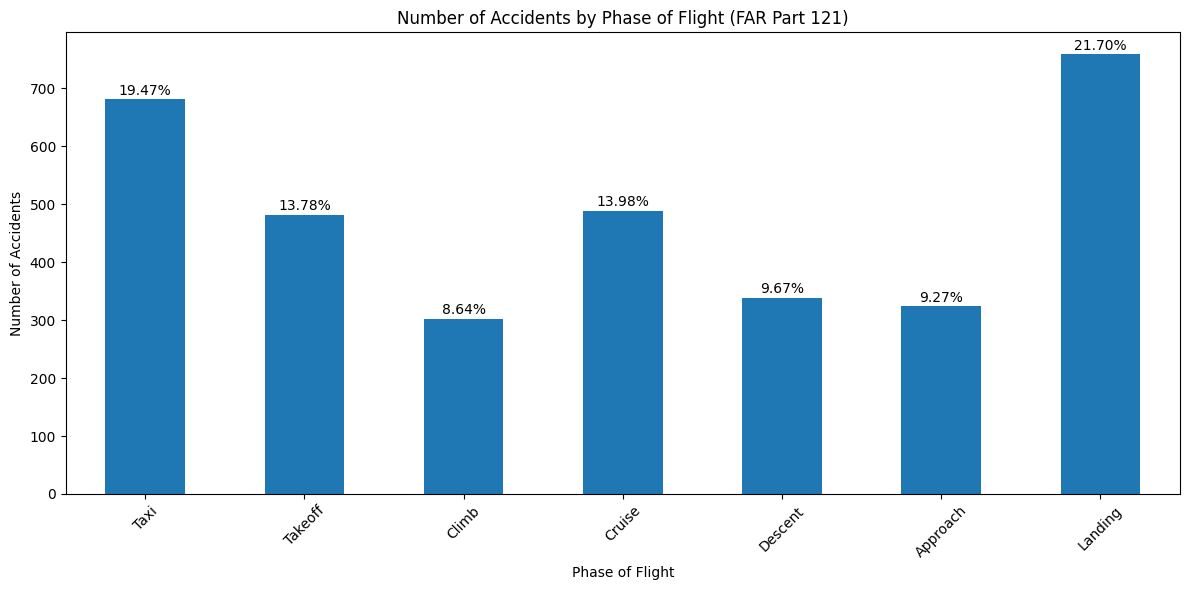

Phase_Group
Landing          759
Taxi             681
Cruise           489
Takeoff          482
Descent          338
Approach         324
Climb            302
Other/Unknown    122
dtype: int64
Phase_Group
Landing          21.704318
Taxi             19.473835
Cruise           13.983414
Takeoff          13.783243
Descent           9.665428
Approach          9.265084
Climb             8.635974
Other/Unknown     3.488705
dtype: float64


In [136]:
#Filter full_phase_data for PART 121
POF_121 = full_phase_data[full_phase_data['far_part'] == '121']
POF_121['Phase_Group'].value_counts().reindex(phase_order).plot(kind='bar', figsize=(12,6))
for i, v in enumerate(POF_121['Phase_Group'].value_counts().reindex(phase_order)):
    # Replace the value with the percentage
    percentage = (v / POF_121['Phase_Group'].count()) * 100
    plt.text(i, v + 3, f'{percentage:.2f}%', ha='center', va='bottom')
plt.title('Number of Accidents by Phase of Flight (FAR Part 121)')
plt.xlabel('Phase of Flight')
plt.ylabel('Number of Accidents')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
len(POF_121)
#calcuate percentages for POF_121
phase_summary_121 = POF_121.groupby('Phase_Group').size().sort_values(ascending=False)
print(phase_summary_121)
#phase percentages
phase_percentages_121 = (phase_summary_121 / phase_summary_121.sum()) * 100
print(phase_percentages_121)

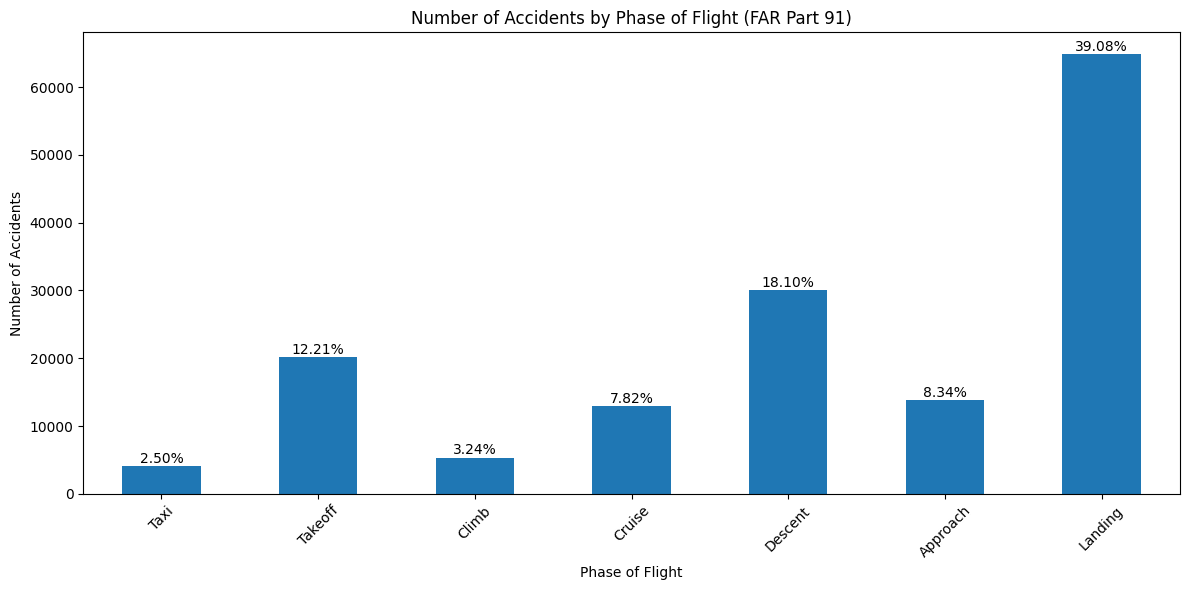

Phase_Group
Landing          64821
Descent          30022
Takeoff          20245
Other/Unknown    14450
Approach         13827
Cruise           12972
Climb             5375
Taxi              4142
dtype: int64
Phase_Group
Landing          39.083170
Descent          18.101463
Takeoff          12.206519
Other/Unknown     8.712482
Approach          8.336850
Cruise            7.821337
Climb             3.240802
Taxi              2.497377
dtype: float64


In [137]:
#Filter full_phase_data for PART 91
POF_91 = full_phase_data[full_phase_data['far_part'] == '91']
POF_91['Phase_Group'].value_counts().reindex(phase_order).plot(kind='bar', figsize=(12,6))
for i, v in enumerate(POF_91['Phase_Group'].value_counts().reindex(phase_order)):
    # Replace the value with the percentage
    percentage = (v / POF_91['Phase_Group'].count()) * 100
    plt.text(i, v + 3, f'{percentage:.2f}%', ha='center', va='bottom')
plt.title('Number of Accidents by Phase of Flight (FAR Part 91)')
plt.xlabel('Phase of Flight')
plt.ylabel('Number of Accidents')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
len(POF_91)
#calcuate percentages for POF_91
phase_summary_91 = POF_91.groupby('Phase_Group').size().sort_values(ascending=False)
print(phase_summary_91)
#phase percentages
phase_percentages_91 = (phase_summary_91 / phase_summary_91.sum()) * 100
print(phase_percentages_91)

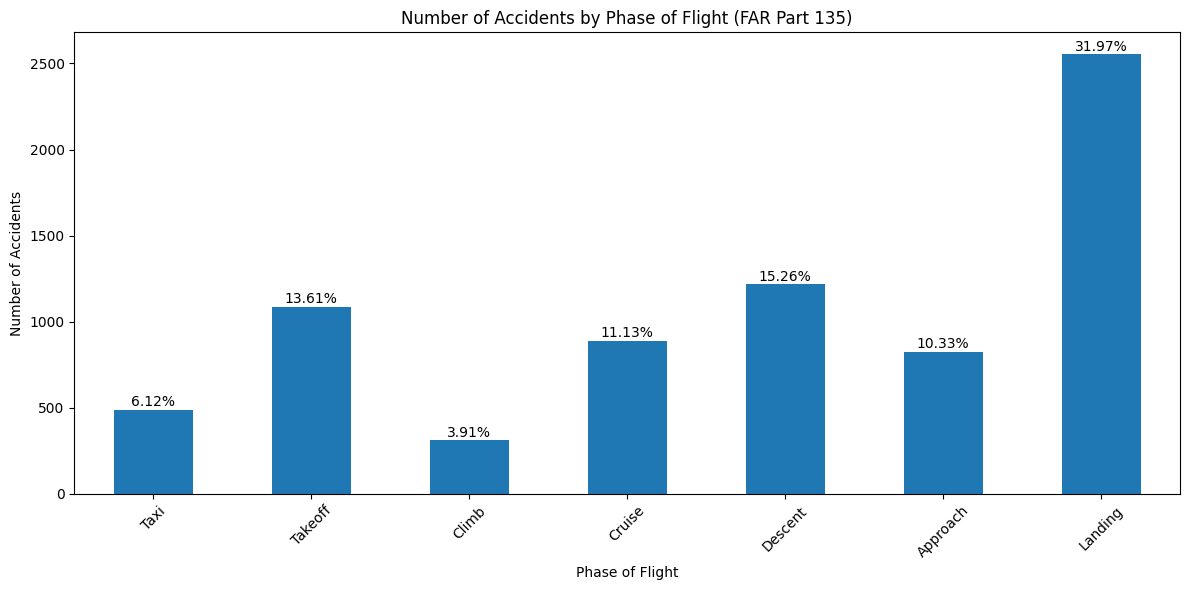

Phase_Group
Landing          2553
Descent          1219
Takeoff          1087
Cruise            889
Approach          825
Other/Unknown     612
Taxi              489
Climb             312
dtype: int64
Phase_Group
Landing          31.968445
Descent          15.264212
Takeoff          13.611320
Cruise           11.131981
Approach         10.330579
Other/Unknown     7.663411
Taxi              6.123216
Climb             3.906837
dtype: float64


In [ ]:
#Filter full_phase_data for PART 135
POF_135 = full_phase_data[full_phase_data['far_part'] == '135']
POF_135['Phase_Group'].value_counts().reindex(phase_order).plot(kind='bar', figsize=(12,6))
for i, v in enumerate(POF_135['Phase_Group'].value_counts().reindex(phase_order)):
    # Replace the value with the percentage
    percentage = (v / POF_135['Phase_Group'].count()) * 100
    plt.text(i, v + 3, f'{percentage:.2f}%', ha='center', va='bottom')
plt.title('Number of Accidents by Phase of Flight (FAR Part 135)')
plt.xlabel('Phase of Flight')
plt.ylabel('Number of Accidents')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
len(POF_135)
#calcuate percentages for POF_135
phase_summary_135 = POF_135.groupby('Phase_Group').size().sort_values(ascending=False)
print(phase_summary_135)
#phase percentages
phase_percentages_135 = (phase_summary_135 / phase_summary_135.sum()) * 100
print(phase_percentages_135)

In [141]:
df_all.head()
df_91 = df_all[df_all['far_part'] == '91']
df_91 = df_91[df_91['dec_latitude'].notna()]
df_121 = df_all[df_all['far_part'] == '121']
df_121 = df_121[df_121['dec_latitude'].notna()]
df_135 = df_all[df_all['far_part'] == '135']
df_135 = df_135[df_135['dec_latitude'].notna()]
print(f'Percentage of Part 91 accidents relative: {(len(df_91) / len(df_all))*100:.2f}%')
print(f'Percentage of Part 121 accidents relative: {(len(df_121) / len(df_all))*100:.2f}%')
print(f'Percentage of Part 135 accidents relative: {(len(df_135) / len(df_all))*100:.2f}%')


Percentage of Part 91 accidents relative: 78.15%
Percentage of Part 121 accidents relative: 2.22%
Percentage of Part 135 accidents relative: 3.69%


In [133]:
######## Heat Map For fun ########
import folium
from folium.plugins import HeatMapWithTime

start_lat = 30.87033
start_long = -85.98852

# Ensure ev_date is datetime
df_all['ev_date'] = pd.to_datetime(df_all['ev_date'], errors='coerce')
df_all['Year'] = df_all['ev_date'].dt.year

# Group accidents by year
years = sorted(df_all['Year'].dropna().unique())

# Create data list: one sublist of [lat, lon] for each year
heat_data = []
for y in years:
    year_df = df_all[df_all['Year'] == y]
    heat_data.append(year_df[['dec_latitude', 'dec_longitude']].dropna().values.tolist())

m = folium.Map(location=[start_lat, start_long],
    zoom_start=8, height= '80%', width='80%'
)

folium.Marker(
    location=[31.33166, -85.71994],
    popup='Fort Rucker, AL',
    icon=folium.Icon(color='green', icon='plane', prefix='fa')
).add_to(m)

folium.Marker(
    location=[30.35180, -87.31913],
    popup='Naval Air Station Pensacola, FL',
    icon=folium.Icon(color='blue', icon='plane', prefix='fa')
).add_to(m)



# Labels for slider
time_index = [str(y) for y in years]

hm = HeatMapWithTime(
    heat_data,
    index=time_index,
    auto_play=True,
    max_opacity=0.6,
    radius=8,
    
)

hm.add_to(m)

m

In [ ]:
#T/F Quantiles are on a 0 to 1 scale
#True or false: in R, pnorm(.25) returns the first quartile of the standard normal distribution

